In [1]:
%load_ext autoreload
%autoreload 2    
%matplotlib inline

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
import numpy as np
import glob
from PIL import Image, ExifTags

# pip install torchsummary
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as fn
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from time import time
import pandas as pd
import random

import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from matplotlib.patches import Polygon, Rectangle
import pylab
pylab.rcParams['figure.figsize'] = (6,6)

# Own imports 
from config import * 
from utils import *
from data_loader import TacoDataset
from eval import *

# speed-up using multithreads
cv2.setUseOptimized(True);
cv2.setNumThreads(8);

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#img_size = 512

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(10, 10, 10, p=0.3),
    A.GaussNoise(p=0.5),
    A.Normalize(), # If you want to visualize - comment this line 
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco',
                            label_fields=['labels'],
                            min_visibility=0.3, # min visibility of the original area in case of a crop
                           )
)

test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco',
                            label_fields=['labels'],
                           )
)

In [4]:
BATCH_SIZE = 16

In [5]:
trainset = TacoDataset( 'train', transforms=train_transform, test_size=0.2) # test_transform for no augment
valset   = TacoDataset('val', transforms=test_transform, test_size=0.2)
testset  = TacoDataset('test', transforms=test_transform, test_size=0.2)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)

In [6]:
loss_function = nn.BCELoss()

model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model = transfer_model_set(model, freeze_convs=False)
optimizer = torch.optim.Adam(model.parameters(), HEAD_LEARNING_RATE)

lr_scheduler = None

In [7]:
NUM_EPOCHS = 10

In [8]:
for epoch in range(NUM_EPOCHS):
    model.train()
    print(f"EPOCH {epoch}/{NUM_EPOCHS}")

    train_loss = []
    train_correct = 0
    train_len = 0
    
    for minibatch_no, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
        
        images = [image for image, _, _ in batch]
        bboxes = [bbox for _, bbox, _ in batch]
        labels = [label for _, _, label in batch]
        
        # Selective search
                
        # Edge boxes
        cropped_images_all, proposals_all, predictions_all = edge_boxes_train(images, bboxes)         
        if len(cropped_images_all) ==0:
            print('no boxes detected')
            break 
        data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)
        
        # CNN
        optimizer.zero_grad()
        output = model(data)[:,0]
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        predicted = output > 0.5
        correct_in_the_item = (target==predicted).sum().cpu().item()
        train_correct += correct_in_the_item
        train_len += data.shape[0]
        print(f'train_loss: {loss:.5f}        Accuracy {correct_in_the_item / len(target):.3f}')
        # break
    continue
    # Test evaluation
    model.eval()
    for batch in val_loader:
        test_images = [image for image, _, _ in batch]
        test_bboxes = [bbox for _, bbox, _ in batch]
        test_labels = [label for _, _, label in batch]
        
        # Selective search
        test_cropped_images_all, test_proposals_all = selective_search_test(test_images, test_bboxes) 
        test_data = torch.stack(test_cropped_images_all).to(device)
        
        with torch.no_grad():
            outputs = model(test_data)[:,0]
        predicted = (outputs > 0.5).tolist()
        
        # Reshaping
        outputs = outputs.tolist()
        new_shape = [len(l) for l in test_proposals_all]
        output_new_shape, predicted_new_shape = [], []
        head = 0
        for l in new_shape:
            output_new_shape.append(outputs[head:l+head])
            predicted_new_shape.append(predicted[head:l+head])
            head += l

        # Filitering classes from background
        predicted_bboxes = list(compress(test_proposals_all, predicted_new_shape))
        output_new_shape = list(compress(output_new_shape, predicted_new_shape))
        
        pred = [dict(
            boxes=torch.FloatTensor(bboxes),
            scores=torch.FloatTensor(output),
            labels=torch.ones(len(output)) # Simplification for Binary
        ) for bboxes, output in zip(predicted_bboxes, output_new_shape)]
        
        target = [dict(
            boxes=torch.FloatTensor(bboxes),
            labels=torch.FloatTensor(label)
        ) for bboxes, label in zip(test_bboxes, test_labels)]
        
        # Computing mAP
        metric = MeanAveragePrecision()
        metric.update(pred, target)
        maps = metric.compute()
        print(f'MAP: {float(maps["map"].detach().cpu()):.3f}          MAP@50: {float(maps["map_50"].detach().cpu()):.3f}          MAP_small: {float(maps["map_small"].detach().cpu()):.3f}          MAP_large: {float(maps["map_large"].detach().cpu()):.3f}')
        

EPOCH 0/10


  0%|          | 0/57 [00:00<?, ?it/s]

/zhome/7c/2/136917/Desktop/venv_1/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/tmp/ipykernel_250214/1762985707.py:22: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)


train_loss: 0.73966        Accuracy 0.469
train_loss: 0.56464        Accuracy 0.705
train_loss: 0.71827        Accuracy 0.568
train_loss: 0.41717        Accuracy 0.778
train_loss: 0.39874        Accuracy 0.854
train_loss: 0.47490        Accuracy 0.750
train_loss: 0.35634        Accuracy 0.833
train_loss: 0.77937        Accuracy 0.722
train_loss: 0.75486        Accuracy 0.744
train_loss: 0.40116        Accuracy 0.846
train_loss: 1.15748        Accuracy 0.375
train_loss: 0.47346        Accuracy 0.722
train_loss: 0.55479        Accuracy 0.647
train_loss: 0.70754        Accuracy 0.577
train_loss: 0.47880        Accuracy 0.762
train_loss: 0.47130        Accuracy 0.782
train_loss: 0.55554        Accuracy 0.755
train_loss: 0.45550        Accuracy 0.780
train_loss: 0.40938        Accuracy 0.875
train_loss: 0.41100        Accuracy 0.900
train_loss: 0.51697        Accuracy 0.733
train_loss: 0.61255        Accuracy 0.706
train_loss: 0.27093        Accuracy 0.926
train_loss: 0.53846        Accurac

  0%|          | 0/57 [00:00<?, ?it/s]

train_loss: 0.35677        Accuracy 0.881
train_loss: 0.39585        Accuracy 0.771
train_loss: 0.52164        Accuracy 0.755
train_loss: 0.35714        Accuracy 0.843
train_loss: 0.51901        Accuracy 0.745
train_loss: 0.39962        Accuracy 0.791
train_loss: 0.62335        Accuracy 0.665
train_loss: 0.57119        Accuracy 0.738
train_loss: 0.92401        Accuracy 0.571
train_loss: 0.54125        Accuracy 0.752
train_loss: 0.58451        Accuracy 0.753
train_loss: 0.52450        Accuracy 0.797
train_loss: 0.65915        Accuracy 0.642
train_loss: 0.32048        Accuracy 0.864
train_loss: 1.00372        Accuracy 0.529
train_loss: 0.40386        Accuracy 0.826
train_loss: 0.49698        Accuracy 0.777
train_loss: 0.30919        Accuracy 0.900
train_loss: 0.41944        Accuracy 0.802
train_loss: 0.46225        Accuracy 0.783
train_loss: 0.47679        Accuracy 0.809
train_loss: 0.51202        Accuracy 0.806
train_loss: 0.30572        Accuracy 0.958
train_loss: 0.34665        Accurac

  0%|          | 0/57 [00:00<?, ?it/s]

train_loss: 0.41938        Accuracy 0.798
train_loss: 0.47501        Accuracy 0.728
train_loss: 0.20319        Accuracy 0.953
train_loss: 0.43542        Accuracy 0.795
train_loss: 0.46197        Accuracy 0.759
train_loss: 0.46345        Accuracy 0.767
train_loss: 0.50763        Accuracy 0.762
train_loss: 0.61168        Accuracy 0.708
train_loss: 0.60845        Accuracy 0.778
train_loss: 0.59664        Accuracy 0.732
train_loss: 0.58314        Accuracy 0.765
train_loss: 0.50871        Accuracy 0.770
train_loss: 0.40585        Accuracy 0.800
train_loss: 0.42095        Accuracy 0.770
train_loss: 0.68254        Accuracy 0.658
train_loss: 0.64641        Accuracy 0.889
train_loss: 0.59581        Accuracy 0.724
train_loss: 0.28296        Accuracy 0.939
train_loss: 0.33846        Accuracy 0.839
train_loss: 0.50767        Accuracy 0.787
train_loss: 0.43264        Accuracy 0.814
train_loss: 0.43571        Accuracy 0.805
train_loss: 0.53404        Accuracy 0.791
train_loss: 0.23560        Accurac

  0%|          | 0/57 [00:00<?, ?it/s]

train_loss: 0.34379        Accuracy 0.875
train_loss: 0.58752        Accuracy 0.732
train_loss: 0.40970        Accuracy 0.837
train_loss: 0.83999        Accuracy 0.576
train_loss: 0.36928        Accuracy 0.852
train_loss: 0.77402        Accuracy 0.615
train_loss: 0.19469        Accuracy 1.000
train_loss: 0.63978        Accuracy 0.667
train_loss: 0.52307        Accuracy 0.712
train_loss: 0.49779        Accuracy 0.787
train_loss: 0.58461        Accuracy 0.686
train_loss: 0.25052        Accuracy 0.966
train_loss: 0.37019        Accuracy 0.876
train_loss: 0.38553        Accuracy 0.873
train_loss: 0.42578        Accuracy 0.838
train_loss: 0.49564        Accuracy 0.724
train_loss: 0.44480        Accuracy 0.765
train_loss: 0.49571        Accuracy 0.680
train_loss: 0.38708        Accuracy 0.808
train_loss: 0.29907        Accuracy 0.929
train_loss: 0.36897        Accuracy 0.815
train_loss: 0.55212        Accuracy 0.733
train_loss: 0.41512        Accuracy 0.764
train_loss: 0.42540        Accurac

  0%|          | 0/57 [00:00<?, ?it/s]

train_loss: 0.40500        Accuracy 0.814
train_loss: 0.46187        Accuracy 0.714
train_loss: 0.47148        Accuracy 0.754
train_loss: 0.31643        Accuracy 0.864
train_loss: 0.34064        Accuracy 0.838
train_loss: 0.42923        Accuracy 0.847
train_loss: 0.50449        Accuracy 0.829
train_loss: 0.35821        Accuracy 0.831
train_loss: 0.34947        Accuracy 0.863
train_loss: 0.75529        Accuracy 0.581
train_loss: 0.37980        Accuracy 0.788
train_loss: 0.54950        Accuracy 0.735
train_loss: 0.45615        Accuracy 0.762
train_loss: 0.79841        Accuracy 0.520
train_loss: 0.65492        Accuracy 0.616
train_loss: 0.28326        Accuracy 0.926
train_loss: 0.34638        Accuracy 0.856
train_loss: 0.51201        Accuracy 0.645
train_loss: 0.39855        Accuracy 0.828
train_loss: 0.40935        Accuracy 0.775
train_loss: 0.20375        Accuracy 0.949
train_loss: 0.25615        Accuracy 0.946
train_loss: 0.54557        Accuracy 0.719
train_loss: 0.38318        Accurac

  0%|          | 0/57 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2a649a7880>
Traceback (most recent call last):
  File "/zhome/7c/2/136917/Desktop/venv_1/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/zhome/7c/2/136917/Desktop/venv_1/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/appl/python/3.10.11/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


train_loss: 0.50185        Accuracy 0.738
train_loss: 0.64903        Accuracy 0.741
train_loss: 0.67380        Accuracy 0.681
train_loss: 0.55537        Accuracy 0.689
train_loss: 0.46029        Accuracy 0.785
train_loss: 0.34192        Accuracy 0.866
train_loss: 0.53950        Accuracy 0.762
train_loss: 0.26820        Accuracy 0.925
train_loss: 0.45964        Accuracy 0.872
train_loss: 0.40074        Accuracy 0.886
train_loss: 0.64538        Accuracy 0.583
train_loss: 0.74190        Accuracy 0.562
train_loss: 0.33367        Accuracy 0.853
train_loss: 0.42705        Accuracy 0.780
train_loss: 0.39226        Accuracy 0.812
train_loss: 0.50160        Accuracy 0.727
train_loss: 0.23427        Accuracy 0.936
train_loss: 0.42992        Accuracy 0.801
train_loss: 0.39795        Accuracy 0.824
train_loss: 0.38668        Accuracy 0.797
train_loss: 0.37326        Accuracy 0.817
train_loss: 0.42142        Accuracy 0.818
train_loss: 0.55505        Accuracy 0.667
train_loss: 0.28870        Accurac

  0%|          | 0/57 [00:00<?, ?it/s]

train_loss: 0.28304        Accuracy 0.964
train_loss: 0.38602        Accuracy 0.853
train_loss: 0.17997        Accuracy 1.000
train_loss: 0.61837        Accuracy 0.750
train_loss: 0.64502        Accuracy 0.667
train_loss: 0.46386        Accuracy 0.781
train_loss: 0.40798        Accuracy 0.827
train_loss: 0.38700        Accuracy 0.909
train_loss: 0.62819        Accuracy 0.649
train_loss: 0.37541        Accuracy 0.838
train_loss: 0.46184        Accuracy 0.738
train_loss: 0.23723        Accuracy 0.919
train_loss: 0.29064        Accuracy 0.910
train_loss: 0.33982        Accuracy 0.786
train_loss: 0.58238        Accuracy 0.667
train_loss: 0.19157        Accuracy 0.955
train_loss: 0.46700        Accuracy 0.805
train_loss: 0.33606        Accuracy 0.884
train_loss: 0.35416        Accuracy 0.857
train_loss: 0.26381        Accuracy 0.938
train_loss: 0.50509        Accuracy 0.730
train_loss: 0.74692        Accuracy 0.643
train_loss: 0.19199        Accuracy 0.952
train_loss: 0.50987        Accurac

  0%|          | 0/57 [00:00<?, ?it/s]

train_loss: 0.57369        Accuracy 0.668
train_loss: 0.70720        Accuracy 0.571
train_loss: 0.47225        Accuracy 0.700
train_loss: 0.45190        Accuracy 0.796
train_loss: 0.54788        Accuracy 0.735
train_loss: 0.62088        Accuracy 0.685
train_loss: 0.49728        Accuracy 0.784
train_loss: 0.72811        Accuracy 0.534
train_loss: 0.67390        Accuracy 0.590
train_loss: 0.84718        Accuracy 0.444
train_loss: 0.46689        Accuracy 0.800
train_loss: 0.49311        Accuracy 0.816
train_loss: 0.58102        Accuracy 0.679
train_loss: 0.50272        Accuracy 0.795
train_loss: 0.75844        Accuracy 0.475
train_loss: 0.55431        Accuracy 0.725
train_loss: 0.46769        Accuracy 0.857
train_loss: 0.63324        Accuracy 0.623
train_loss: 0.51273        Accuracy 0.741
train_loss: 0.50722        Accuracy 0.789
train_loss: 0.43266        Accuracy 0.762
train_loss: 0.47130        Accuracy 0.886
train_loss: 0.54932        Accuracy 0.708
train_loss: 0.43237        Accurac

  0%|          | 0/57 [00:00<?, ?it/s]

train_loss: 0.35369        Accuracy 0.809
train_loss: 0.36598        Accuracy 0.845
train_loss: 0.64078        Accuracy 0.660
train_loss: 0.83652        Accuracy 0.601
train_loss: 0.41642        Accuracy 0.865
train_loss: 0.20075        Accuracy 0.974
train_loss: 0.33732        Accuracy 0.889
train_loss: 0.45453        Accuracy 0.778
train_loss: 0.75469        Accuracy 0.556
train_loss: 0.28278        Accuracy 0.875
train_loss: 0.59453        Accuracy 0.706
train_loss: 0.95447        Accuracy 0.600
train_loss: 0.36309        Accuracy 0.829
train_loss: 0.46343        Accuracy 0.821
train_loss: 0.58386        Accuracy 0.706
train_loss: 0.58192        Accuracy 0.654
train_loss: 0.45600        Accuracy 0.755
train_loss: 0.40455        Accuracy 0.826
train_loss: 0.29298        Accuracy 0.905
train_loss: 0.52463        Accuracy 0.818
train_loss: 0.47307        Accuracy 0.758
train_loss: 0.51517        Accuracy 0.744
train_loss: 0.39059        Accuracy 0.857
train_loss: 0.30521        Accurac

  0%|          | 0/57 [00:00<?, ?it/s]

train_loss: 0.37589        Accuracy 0.867
train_loss: 0.36784        Accuracy 0.955
train_loss: 0.32884        Accuracy 0.891
train_loss: 0.30773        Accuracy 0.918
train_loss: 0.51986        Accuracy 0.661
train_loss: 0.31323        Accuracy 0.919
train_loss: 0.32265        Accuracy 0.917
train_loss: 0.66953        Accuracy 0.640
train_loss: 0.38749        Accuracy 0.864
train_loss: 0.31455        Accuracy 0.873
train_loss: 0.24968        Accuracy 0.971
train_loss: 0.39597        Accuracy 0.919
train_loss: 0.45496        Accuracy 0.864
train_loss: 0.28760        Accuracy 0.895
train_loss: 0.28205        Accuracy 0.913
train_loss: 0.38473        Accuracy 0.833
train_loss: 0.41047        Accuracy 0.854
train_loss: 0.33855        Accuracy 0.855
train_loss: 0.43536        Accuracy 0.818
train_loss: 0.41987        Accuracy 0.804
train_loss: 0.60752        Accuracy 0.722
train_loss: 0.64708        Accuracy 0.722
train_loss: 0.83562        Accuracy 0.621
train_loss: 0.32121        Accurac

In [10]:
data.shape

torch.Size([3, 3, 150, 150])

In [11]:
model(data).shape

torch.Size([3, 1])

In [12]:
predicted = output > 0.5
train_correct += (target==predicted).sum().cpu().item()
        

In [13]:
(target==predicted).sum().cpu().item()

2

In [14]:
predicted

tensor([ True, False, False], device='cuda:0')

In [15]:
import time 

In [16]:
len(batch)

4

In [17]:
images = [image for image, _, _ in batch]
bboxes = [bbox for _, bbox, _ in batch]
labels = [label for _, _, label in batch]
labels

[[tensor(1)],
 [tensor(1), tensor(1)],
 [tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1)],
 [tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1)]]

In [25]:
k = 2

cropped_images_all, proposals_all, predictions_all = edge_boxes_train([images[k]], [bboxes[k]])
data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)

/tmp/ipykernel_250214/1185709562.py:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)


In [26]:
data.shape

torch.Size([40, 3, 150, 150])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([40])


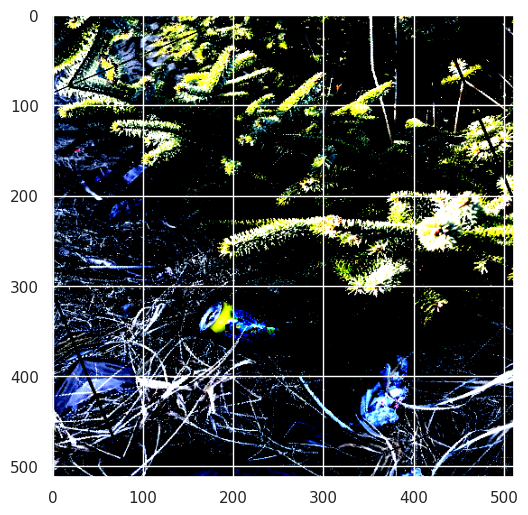

In [27]:
result = model(data)[:, 0]
print(result.shape)
plt.imshow(images[k].detach().permute(1,2,0).cpu().numpy())

In [28]:
print(result.argsort())
print(result)

tensor([25, 11, 16, 23,  4, 24,  0,  1,  7, 39,  2, 15, 14,  6,  3,  5, 26, 19,
         8, 10, 29, 35, 34, 12, 31, 17,  9, 28, 13, 30, 33, 20, 27, 36, 38, 32,
        37, 21, 18, 22], device='cuda:0')
tensor([0.1364, 0.1412, 0.1952, 0.3097, 0.0793, 0.3631, 0.2888, 0.1477, 0.5288,
        0.7464, 0.6324, 0.0193, 0.6966, 0.7829, 0.2840, 0.2077, 0.0284, 0.7347,
        0.9164, 0.4566, 0.8239, 0.9011, 0.9391, 0.0286, 0.1095, 0.0193, 0.3740,
        0.8453, 0.7820, 0.6714, 0.7919, 0.7014, 0.8821, 0.8179, 0.6859, 0.6778,
        0.8487, 0.8930, 0.8752, 0.1662], device='cuda:0',
       grad_fn=<SelectBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


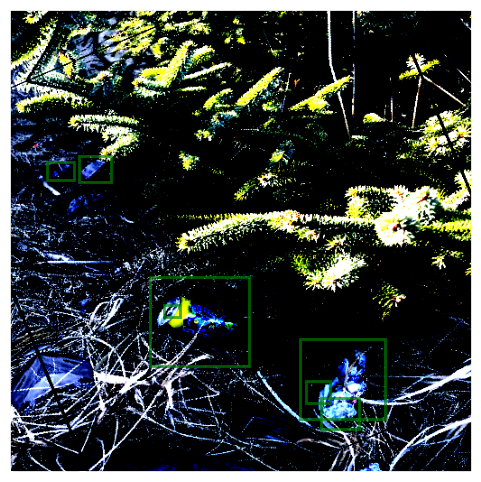

In [29]:
fig,ax = plt.subplots(1)

plt.imshow(images[k].permute(1,2,0))
plt.xticks([])
plt.yticks([])

# Show annotations
for ann in bboxes[k]:
    [x, y, x1, y1] = ann
    rect = Rectangle((x,y),x1,y1,linewidth=2,edgecolor='green',
                     facecolor='none', alpha=0.7)
    ax.add_patch(rect)
#plt.savefig(f'imgs/output_{img_idx}.png')
plt.show()

In [75]:
from eval import *
#nms_pytorch(proposals_all, 0.5, result)
suppress_results = NMS(stack_results(proposals_all, result, device), 0.3 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


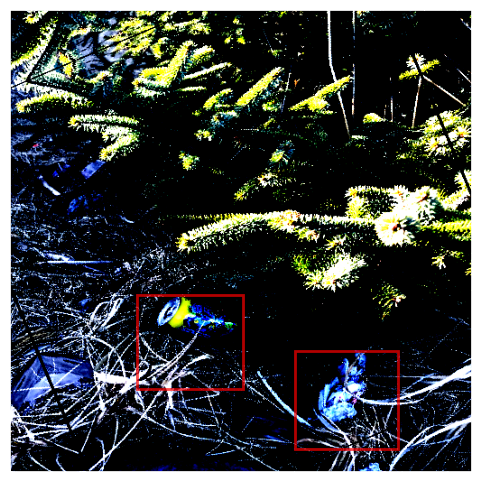

In [76]:
fig,ax = plt.subplots(1)

plt.imshow(images[k].permute(1,2,0))
plt.xticks([])
plt.yticks([])

# Show annotations
for i, ann in enumerate(suppress_results):
    x, y, x1, y1,_ = ann.detach().cpu().numpy()
    if predictions_all[i]:
        edge_col = 'green'
    else:
        edge_col = 'red'
    rect = Rectangle((x,y),x1,y1,linewidth=2,edgecolor=edge_col,
                     facecolor='none', alpha=0.7)
    ax.add_patch(rect)
#plt.savefig(f'imgs/output_{img_idx}.png')
plt.show()

In [22]:
data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)
        

In [23]:
plt.imshow(images[k].permute(1,2,0).detach().cpu().numpy()[y:y+h, x:x+w])

NameError: name 'h' is not defined

In [ ]:
plt.imshow(fn.crop(, x, y, w, h ))

In [ ]:
target

In [ ]:
plt.imshow(cropped_images_all[1].detach().permute(1,2,0).cpu().numpy())

In [24]:
target

tensor([0.], device='cuda:0')

In [ ]:
plt.imshow(data[3].detach().permute(1,2,0).cpu().numpy())

In [ ]:

# CNN
optimizer.zero_grad()
output = model(data)[:,0]
loss = loss_function(output, target)
loss.backward()
optimizer.step()

train_loss.append(loss.item())
predicted = output > 0.5
train_correct += (target==predicted).sum().cpu().item()
train_len += data.shape[0]
print(f'train_loss: {loss:.5f}')
# break
        

In [ ]:
optimizer.zero_grad()
output = model(data)[:,0]
        